This is a simple ODE system solved with a PINN model using the DeepXDE library.

\\
\begin{equation}
\frac{\partial y_1}{\partial t} = y_2 \hspace{1cm} \frac{\partial y_2}{\partial t} = -y_1  \hspace{1cm} t∈[0,10]
\end{equation}

\\
\begin{equation}
y_1(0) = 0 \hspace{1cm} y_2(0) = 1
\end{equation}

\\

Test losses after 10000 epochs are approximately:

*In accordance to y outputs:* **8.17e-06**, **6.84e-06**

*In accordance to boundary conditions:* **9.89e-09**, **7.93e-09**

*In accordance to the known solution:* **5.37e-03**

In [ ]:
# Importing libraries

!pip install deepxde
import deepxde as dde
from deepxde.backend import tf
import numpy as np

     |████████████████████████████████| 121 kB 8.2 MB/s 
     |████████████████████████████████| 100 kB 5.9 MB/s 


Deepxde backend not selected or invalid. Assuming tensorflow.compat.v1 for now.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term



In [17]:
# Define computational geometry

geom = dde.geometry.TimeDomain(0, 10)

In [ ]:
# Define ode system

def ode_system(x,y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    dy1_x = dde.grad.jacobian(y1, x)
    dy2_x = dde.grad.jacobian(y2, x)
    return [dy1_x - y2, dy2_x + y1]

In [16]:
# Define boundary conditions

def boundary(x, _):
    return np.isclose(x[0], 0)

ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)

In [ ]:
# Define known solution

def sol(x):
    return np.hstack((np.sin(x), np.cos(x)))

In [ ]:
# Accumulate all the data for the model

data = dde.data.PDE(geom, ode_system, [ic1, ic2], num_domain=100, num_boundary=2, solution = sol, num_test=100)

/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  total_n_samples))


In [ ]:
# Create the neural network

layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)

In [ ]:
# Build and train the model

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

losshistory, train_state = model.train(epochs=10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.086857 s



/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 0.627354 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [1.52e-01, 9.90e-03, 0.00e+00, 1.00e+00]    [1.53e-01, 9.58e-03, 0.00e+00, 1.00e+00]    [1.02e+00]    
1000      [7.08e-03, 5.93e-03, 1.80e-08, 2.22e-04]    [7.34e-03, 5.67e-03, 1.80e-08, 2.22e-04]    [7.11e-01]    
2000      [5.27e-03, 4.12e-03, 5.93e-07, 1.14e-04]    [5.37e-03, 4.04e-03, 5.93e-07, 1.14e-04]    [5.82e-01]    
3000      [2.50e-03, 2.91e-03, 1.49e-06, 5.36e-05]    [2.56e-03, 2.74e-03, 1.49e-06, 5.36e-05]    [4.12e-01]    
4000      [5.98e-04, 1.16e-03, 2.36e-06, 8.69e-06]    [6.09e-04, 8.86e-04, 2.36e-06, 8.69e-06]    [1.90e-01]    
5000      [1.52e-04, 1.93e-04, 3.22e-07, 1.47e-08]    [1.44e-04, 1.19e-04, 3.22e-07, 1.47e-08]    [6.49e-02]    
6000      [5.80e-05, 6.18e-05, 1.00e-07, 1.32e-07]    [4.87e-05, 3.90e-05, 1.00e-07, 1.32e-07]    [2.68e-02]    
7000      [3.51e-05, 3.5

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


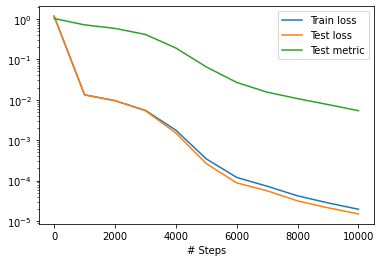

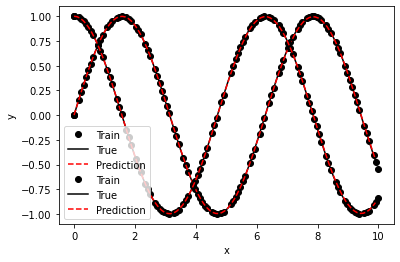

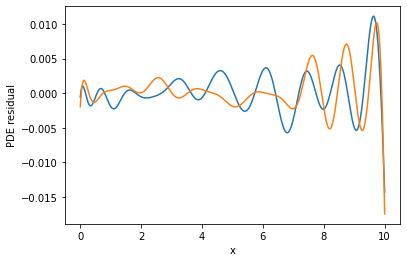

In [ ]:
# Generating plots of the results.

import matplotlib.pyplot as plt

dde.saveplot(losshistory, train_state, issave=True, isplot=True)
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=ode_system)

plt.figure()
plt.plot(x, y[0])
plt.plot(x, y[1])
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()